In [1]:
from scipy import *
import numpy as np
import WLanalysis
from matplotlib import pyplot

In [2]:
########### generate parameters for all models for emulator
########### also generate parameters for fisher derivatives

params = genfromtxt('cosmo_params_all.txt',usecols=[2,3,4])
fidu_params = (0.1, 0.3, 2.1)
ellmax = 3000

########### some constants
z_source = arange(0.5,3,0.5)
Nsum = 210**2 ##### this is the total pixel in mat's downgraded map
fn_list = genfromtxt('cosmo_params_all.txt',usecols=1, dtype='string')
Nc = 3 ## compression for 2dpdf
Nmin = 100 ## min number of counts in a bin to include
#print fn_list[10]

In [3]:
from matplotlib.patches import Ellipse
def plotEllipse(pos,P,edge,ls,ilabel,ax):
    '''plot the contour for covariance p
    where position is the center position
    p is the covariance [2,2] matirx'''
    U, s, Vh = svd(P) 
    orient = math.atan2(U[1,0],U[0,0])*180/pi
    ellipsePlot = Ellipse(xy=pos, width=2.0*math.sqrt(s[0]), 
                          height=2.0*math.sqrt(s[1]), angle=orient,edgecolor=edge, fill = 0, label=ilabel,ls=ls,linewidth=1)
    ax.add_patch(ellipsePlot)
    return ellipsePlot

In [4]:
def Fisher(covI, der, ir = 0.05, skyscaling= 1.0, Nf=1e4, Na=1e3):
    '''
    Input: 
    covariance inverse matrix (Nbin, Nbin)
    derivatives (Nparams, Nbin), where Nparams is the number of parameters 
    skyscaling = area_sims / area_actual_survey = 12.25/2e4 for our sim and LSST
    Return the Fisher matrix
    '''
    #print 'Nf, Na:', Nf, Na 
    dparam = array([0.1, 0.3, 2.1]) * ir
    Nparams, Nbin = der.shape
    F = zeros( shape= (Nparams, Nparams))
    for i in range(Nparams):
        for j in range(Nparams):
            dA, dB = der[i], der[j]
            Mij = mat(dA).T*mat(dB) + mat(dB).T*mat(dA)  
            F [i,j]= 0.5*trace(covI*Mij)
            F [i,j] -= Nbin/(Nf*dparam[i]*dparam[j])
            #if i==j:
            F [i,j] -= Nbin/(Na*dparam[i]*dparam[j])
    F /= skyscaling
    Ferr = real(sqrt(mat(F).I)) [range(Nparams), range(Nparams)]
    return F, Ferr

In [5]:
########## generate average statistics for emulator 

### 2d pdf
pdf2dI = array([load('stats_avg/output_eb_5000_s4_ALL_igalXicmb_2dpdf_%.1f_5.0_5.0.npy'
                     %(iz)) for iz in z_source])
pdf2dN = array([load('stats_avg/output_eb_5000_s4_ALL_galXcmb_2dpdf_%.1f_5.0_5.0.npy'
                     %(iz)) for iz in z_source])

### 1d pdf, this includes all bins, original 1dpdf
pdfgalI = sum(array([load('stats_avg/output_eb_5000_s4_ALL_igal_pdf_%.1f_5.0.npy'
                         %(iz))[:,:60] for iz in z_source]).reshape(5,101,60/Nc, Nc), axis=-1)
pdfgalN = sum(array([load('stats_avg/output_eb_5000_s4_r100_ALL_gal_pdf_%.1f_5.0.npy'
                         %(iz))[:,:60] for iz in z_source]).reshape(5,101,60/Nc, Nc), axis=-1)
pdf1dI, pdf1dN = pdfgalI, pdfgalN

############# below 6 lines are the final ones to be used
#pdfgalI = sum(sum(pdf2dI, axis=2)[:,:,:60].reshape(5,101,60/Nc, Nc), axis=-1)
#pdfgalN = sum(sum(pdf2dN, axis=2)[:,:,:60].reshape(5,101,60/Nc, Nc), axis=-1)

#pdfcmbI = sum(sum(pdf2dI, axis=-1)[0,:,:60].reshape(101,60/Nc, Nc), axis=-1).reshape(1,101,-1)
#pdfcmbN = sum(sum(pdf2dN, axis=-1)[0,:,:60].reshape(101,60/Nc, Nc), axis=-1).reshape(1,101,-1)

#pdf1dI = concatenate([pdfgalI, pdfcmbI],axis=0)
#pdf1dN = concatenate([pdfgalN, pdfcmbN],axis=0)

### power spectrum from mat
psI_Mat = array([load('stats_avg/output_eb_5000_s4_ALL_igalXigal_%.1f_%.1f.npy'
                     %(iz, iz)) for iz in z_source])
#psN_first_Mat = array([load('stats_avg/output_eb_5000_s4_first_ALL_galXgal_%.1f_%.1f.npy'
#                      %(iz, iz)) for iz in z_source])
#psN_Mat = psN_first_Mat
psN_Mat = array([load('stats_avg/output_eb_5000_s4_ALL_galXgal_%.1f_%.1f.npy'
                      %(iz, iz)) for iz in z_source])

### power spectrum from Jose
ellJ, testPS = load('ObsFeb2018_Spec/%s/Maps05/PS_KN_s0.00_z0.50_ng08.83_b050_Mean.npy'%(fn_list[1]))
idxJ = where((ellJ<ellmax) & (testPS>0) )[0]

psI_Jose = array([[mean(load('/Users/jia/Dropbox/fisher/powerspectrum_noiseless/%s_PS_50_z%02d.npy'
        %(icosmo,iz*10))[1:],axis=0) for icosmo in fn_list[1:]] for iz in z_source])[:,:,idxJ]
psN_Jose = array([load('ObsFeb2018_Spec/%s/Tomography/PS_KN_s0.00_ztomo_ng44.85_b050_Mean_sc.npy'
        %(icosmo)) for icosmo in fn_list[1:]]).reshape(100, 5, -1)[:,:,idxJ]


print pdf2dI.shape, pdf2dN.shape
print pdf1dI.shape, pdf1dN.shape 
print pdfgalI.shape#, pdfcmbI.shape
print pdfgalN.shape#, pdfcmbN.shape
print psI_Mat.shape, psN_Mat.shape
print psI_Jose.shape, psN_Jose.shape, idxJ.shape


######### reshape/rebin the stats
pdf2dI_flat0 = swapaxes(sum(pdf2dI[:,:,:,:60].reshape(5, 101, 60/Nc, Nc, 60/Nc, Nc), axis=(-1,-3)), 0, 1).reshape(101,-1)
idx_2dI = where(pdf2dI_flat0[0]>Nmin)[0]
pdf2dI_flat = pdf2dI_flat0 [:, idx_2dI]

pdf2dN_flat0 = swapaxes(sum(pdf2dN[:,:,:,:60].reshape(5, 101, 60/Nc, Nc, 60/Nc, Nc), axis=(-1,-3)), 0, 1).reshape(101,-1)
idx_2dN = where(pdf2dN_flat0[0]>Nmin)[0]
pdf2dN_flat = pdf2dN_flat0 [:, idx_2dI]

######## this has no binning
# pdf1dI_flat0 = swapaxes(pdf1dI[:,:,:60],0,1).reshape(101,-1)
# idx_1dI = where(pdf1dI_flat0[0]>Nmin)[0]
# pdf1dI_flat = pdf1dI_flat0[:,idx_1dI]

# pdf1dN_flat0 = swapaxes(pdf1dN[:,:,:60],0,1).reshape(101,-1)
# idx_1dN = where(pdf1dN_flat0[0]>Nmin)[0]
# pdf1dN_flat = pdf1dN_flat0[:,idx_1dI]

pdf1dI_flat0 = swapaxes(pdf1dI,0,1).reshape(101,-1)
idx_1dI = where(pdf1dI_flat0[0]>Nmin)[0]
pdf1dI_flat = pdf1dI_flat0[:,idx_1dI]

pdf1dN_flat0 = swapaxes(pdf1dN,0,1).reshape(101,-1)
idx_1dN = where(pdf1dN_flat0[0]>Nmin)[0]
pdf1dN_flat = pdf1dN_flat0[:,idx_1dI]

psI_Mat_flat = swapaxes(psI_Mat,0,1).reshape(101,-1)
psN_Mat_flat = swapaxes(psN_Mat,0,1).reshape(101,-1)


psI_Jose_flat = swapaxes(psI_Jose,0,1).reshape(100,-1)
psN_Jose_flat = psN_Jose.reshape(100,-1)

print 'flattened'
print pdf2dI_flat.shape, pdf2dN_flat.shape
print pdf1dI_flat.shape, pdf1dN_flat.shape
print psI_Mat_flat.shape,psN_Mat_flat.shape
print psI_Jose_flat.shape,psN_Jose_flat.shape

(5, 101, 60, 80) (5, 101, 60, 80)
(5, 101, 20) (5, 101, 20)
(5, 101, 20)
(5, 101, 20)
(5, 101, 20) (5, 101, 20)
(5, 100, 22) (100, 5, 22) (22,)
flattened
(101, 199) (101, 199)
(101, 47) (101, 47)
(101, 100) (101, 100)
(100, 110) (100, 110)


In [6]:
######### load covariance statistics
pdf2dI_cov = array([load('box5/output_eb_5000_s4/ALL_igalXicmb_2dpdf_%.1f_5.0_5.0.npy'
                     %(iz))[:,:,:60] for iz in z_source])
pdf2dN_cov = array([load('box5/output_eb_5000_s4/ALL_galXcmb_2dpdf_%.1f_5.0_5.0.npy'
                     %(iz))[:,:,:60] for iz in z_source])

pdfgalI_cov = sum(sum(pdf2dI_cov,axis=2).reshape(5, 10000, 60/Nc, Nc), axis=-1)
pdfgalN_cov = sum(sum(pdf2dN_cov,axis=2).reshape(5, 10000, 60/Nc, Nc), axis=-1)

pdfcmbI_cov = sum(sum(pdf2dI_cov[0],axis=-1).reshape(10000, 60/Nc, Nc), axis=-1).reshape(1, 10000, -1)
pdfcmbN_cov = sum(sum(pdf2dN_cov[0],axis=-1).reshape(10000, 60/Nc, Nc), axis=-1).reshape(1, 10000, -1)

pdf1dI_cov = concatenate([pdfgalI_cov, pdfcmbI_cov], axis=0)
pdf1dN_cov = concatenate([pdfgalN_cov, pdfcmbN_cov], axis=0)


print pdf2dI_cov.shape, pdf2dN_cov.shape
print pdfgalI_cov.shape, pdfcmbI_cov.shape
print pdf1dI_cov.shape, pdf1dN_cov.shape

psIMat_cov = swapaxes(array([load('box5/output_eb_5000_s4/ALL_igalXigal_%.1f_%.1f.npy'%(iz,iz))[1000:]
                     for iz in z_source]),0,1).reshape(9000,-1)
psNMat_cov = swapaxes(array([load('box5/output_eb_5000_s4/ALL_galXgal_%.1f_%.1f.npy'%(iz,iz))[1000:]
                     for iz in z_source]),0,1).reshape(9000,-1)

psIJose_cov =  swapaxes(array([load('/Users/jia/Dropbox/fisher/powerspectrum_noiseless/%s_PS_50_z%02d.npy'
                           %(fn_list[0],iz*10))[1:]  for iz in z_source])[:,:,idxJ],0,1).reshape(1000,-1)
psNJose_cov =  load('ObsFeb2018_Spec/%s/Tomography/PS_KN_s0.00_ztomo_ng44.85_b050.npy'
                    %(fn_list[0])).reshape(9999, 5, -1)[:,:,idxJ].reshape(9999,-1)


pdf2dI_cov_flat = swapaxes(sum(pdf2dI_cov.reshape(5,10000, 60/Nc, Nc, 60/Nc, Nc), 
                               axis=(-1, -3)),0,1).reshape(10000,-1)[:, idx_2dI]
pdf2dN_cov_flat = swapaxes(sum(pdf2dN_cov.reshape(5,10000, 60/Nc, Nc, 60/Nc, Nc), 
                               axis=(-1, -3)),0,1).reshape(10000,-1)[:, idx_2dI]

pdf1dI_cov_flat = swapaxes(pdf1dI_cov,0,1).reshape(10000,-1)[:, idx_1dI]
pdf1dN_cov_flat = swapaxes(pdf1dN_cov,0,1).reshape(10000,-1)[:, idx_1dI]

print 'flattened'
print pdf2dI_cov_flat.shape, pdf2dN_cov_flat.shape
print pdf1dI_cov_flat.shape, pdf1dN_cov_flat.shape
print psIMat_cov.shape, psNMat_cov.shape
print psIJose_cov.shape, psNJose_cov.shape

(5, 10000, 60, 60) (5, 10000, 60, 60)
(5, 10000, 20) (1, 10000, 20)
(6, 10000, 20) (6, 10000, 20)
flattened
(10000, 199) (10000, 199)
(10000, 47) (10000, 47)
(9000, 100) (9000, 100)
(1000, 110) (9999, 110)


In [7]:
############ check the difference between projected 1d from 2d vs read 1d
# pdf1dtest = sum(array([load('stats_avg/output_eb_5000_s4_ALL_igal_pdf_%.1f_5.0.npy'
#                          %(iz))[:,:60] for iz in z_source]).reshape(5,101,60/Nc, Nc), axis=-1)
# print pdf1dtest.shape
# print pdfgalI.shape

# f, (ax,ax2)=subplots(2,1,figsize=(10,6))
# ax.plot( pdfgalI[:,0,:].T,':')
# ax.plot( pdf1dtest[:,0,:].T,'-')
# for i in range(5):
#     ax2.plot(range(20),pdf1dtest[i,0,:]-pdfgalI[i,0,:])
# ax2.set_title('from 2d / read 1d')
# ax.set_ylim(-1,10)
# ax2.set_ylim ( -2, 2)
# ax2.set_xlim(0,20)
# show()

(199, 199) (199, 199)
(47, 47) (47, 47)
(100, 100) (100, 100)
(110, 110) (110, 110)


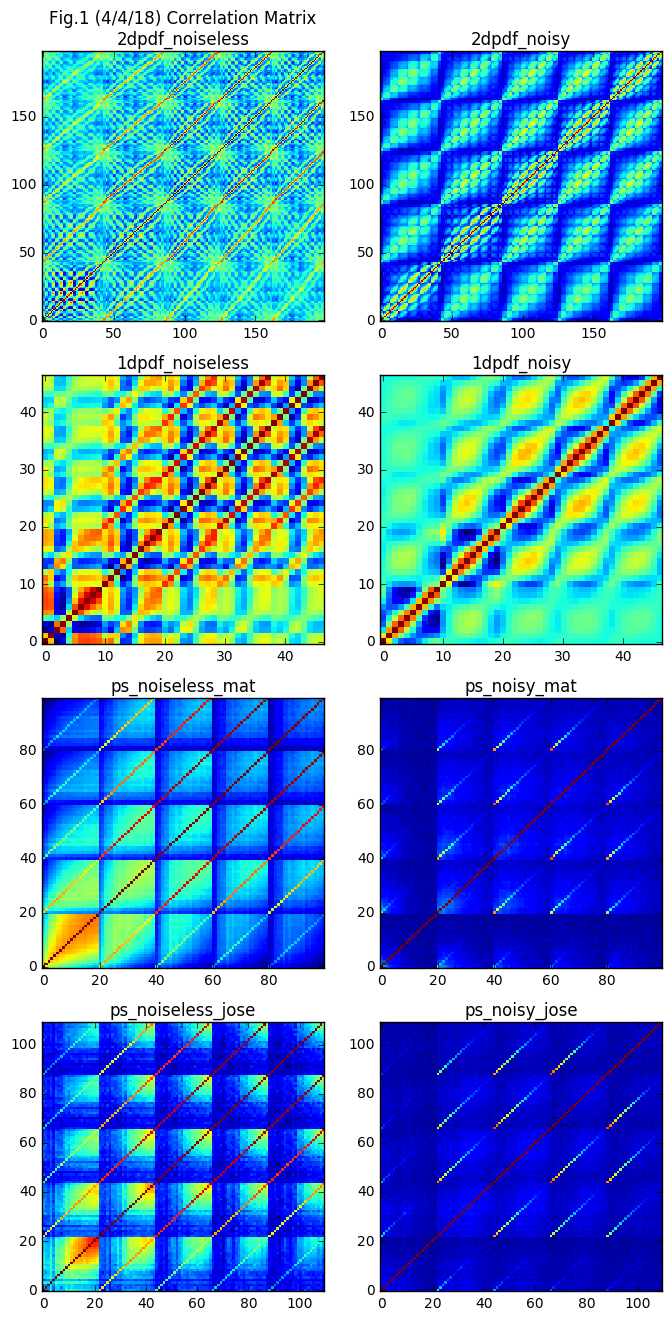

In [8]:
############# build covariances
cov2dI = cov(pdf2dI_cov_flat, rowvar=0)
cov2dN = cov(pdf2dN_cov_flat, rowvar=0)
cov1dI = cov(pdf1dI_cov_flat, rowvar=0)
cov1dN = cov(pdf1dN_cov_flat, rowvar=0)
covpsI_Mat = cov(psIMat_cov, rowvar=0)
covpsN_Mat = cov(psNMat_cov, rowvar=0)
covpsI_Jose = cov(psIJose_cov, rowvar=0)
covpsN_Jose = cov(psNJose_cov, rowvar=0)

print cov2dI.shape, cov2dN.shape
print cov1dI.shape, cov1dN.shape
print covpsI_Mat.shape, covpsN_Mat.shape
print covpsI_Jose.shape, covpsN_Jose.shape

set_names = ['2dpdf_noiseless', '2dpdf_noisy',
             '1dpdf_noiseless', '1dpdf_noisy',
             'ps_noiseless_mat', 'ps_noisy_mat',
             'ps_noiseless_jose', 'ps_noisy_jose']
cov_arr = [cov2dI,cov2dN,
           cov1dI,cov1dN,
           covpsI_Mat,covpsN_Mat,
           covpsI_Jose,covpsN_Jose]

f, axes = subplots(4,2,figsize=(8,16))
for i in range(4):
    axes[i][0].imshow(WLanalysis.corr_mat(cov_arr[i*2]), origin='lower',aspect='auto',interpolation='nearest')
    axes[i][1].imshow(WLanalysis.corr_mat(cov_arr[i*2+1]), origin='lower',aspect='auto',interpolation='nearest')
    axes[i][0].set_title(set_names[i*2])
    axes[i][1].set_title(set_names[i*2+1])
axes[0][0].set_title('Fig.1 (4/4/18) Correlation Matrix\n'+set_names[0])
show()

In [9]:
######### now we compute fisher errors: (1) derivatives (2) Fisher

######### we also add in for power spectrum, noisy covariance, but noiseless derivatives
####### correction factor for using limited number of sims

alpha = lambda Nsim, Np: (Nsim - Np - 2.0) / (Nsim - 1.0)

cov_arr2 = [cov2dI,cov2dN,
           cov1dI,cov1dN,
           covpsI_Mat,covpsN_Mat,covpsN_Mat,
           covpsI_Jose,covpsN_Jose,covpsN_Jose]

stats_arr2 = [pdf2dI_flat[1:], pdf2dN_flat[1:],
             pdf1dI_flat[1:], pdf1dN_flat[1:],
             psI_Mat_flat[1:], psN_Mat_flat[1:],psI_Mat_flat[1:],
             psI_Jose_flat,    psN_Jose_flat,   psI_Jose_flat]

set_names2 = ['2dpdf_noiseless', '2dpdf_noisy',
             '1dpdf_noiseless', '1dpdf_noisy',
             'ps_noiseless_mat', 'ps_noisy_mat (noisy der)', 'ps_noisy_mat (noiseless der)',
             'ps_noiseless_jose', 'ps_noisy_jose (noisy der)', 'ps_noisy_jose (noiseless der)',]

###### add alpha correction
#covI_arr2 = [alpha_arr[i] * mat(cov_arr2[i]*(12.25/2e4)).I for i in range(len(alpha_arr))]
###### do not correct for sky area
#covI_arr2 = [ mat(cov_arr2[i]).I for i in range(len(cov_arr2))]
covI_arr2 = [ mat(cov_arr2[i]*(12.25/2e4)).I for i in range(len(cov_arr2))]


ir = 0.08
params_der = array([array([0.1,0.3,2.1])*(identity(3)*x+ones((3,3))) for x in (ir,-ir)])

der_arr = []
interp_arr = []
for istats in stats_arr2:
    iinterp = WLanalysis.buildInterpolator(istats, params[1:,])
    ider = array([(iinterp(params_der[0][i]) - iinterp(params_der[1][i]))/(fidu_params[i]*ir) for i in range(3)])
    der_arr.append(ider)
    interp_arr.append(iinterp)

# test stability wrt step size
# for ir in (0.01, 0.015, 0.02, 0.05, 0.08, 0.1, 0.15, 0.2):    
#     iF = Fisher(covI_arr2[3], der_arr[3], ir=ir, Na=500.0)
#     ichisq = mat(der_arr[3][0])*covI_arr2[3]*mat(der_arr[3][0]).T
#     print iF[1], set_names2[3], 'step='+str(ir), ichisq

Fisher_arr = [Fisher(covI_arr2[i], der_arr[i], ir=ir, Na=1e3) for i in range(len(covI_arr2))]

print 'Fisher error on [Mnu, omega_m, A_s], step size (%s)'%(ir)
i=0
for iF in Fisher_arr:
    print iF[1], set_names2[i]#, 'step='+str(ir)
    i+=1

Fisher error on [Mnu, omega_m, A_s], step size (0.08)
[ 0.00104085  0.00021992  0.00347581] 2dpdf_noiseless
[ 0.00135475  0.00049108  0.00760801] 2dpdf_noisy
[ 0.00230012  0.00027989  0.00514373] 1dpdf_noiseless
[ 0.00113465  0.00035099  0.00418074] 1dpdf_noisy
[ 0.00133063  0.00037545  0.00634579] ps_noiseless_mat
[ 0.00342628  0.00094295  0.01356197] ps_noisy_mat (noisy der)
[ 0.00665494  0.00132787  0.01949367] ps_noisy_mat (noiseless der)
[ 0.00131833  0.00035788  0.00597106] ps_noiseless_jose
[ 0.00291233  0.00092546  0.01333349] ps_noisy_jose (noisy der)
[ 0.00497059  0.00124582  0.0182128 ] ps_noisy_jose (noiseless der)


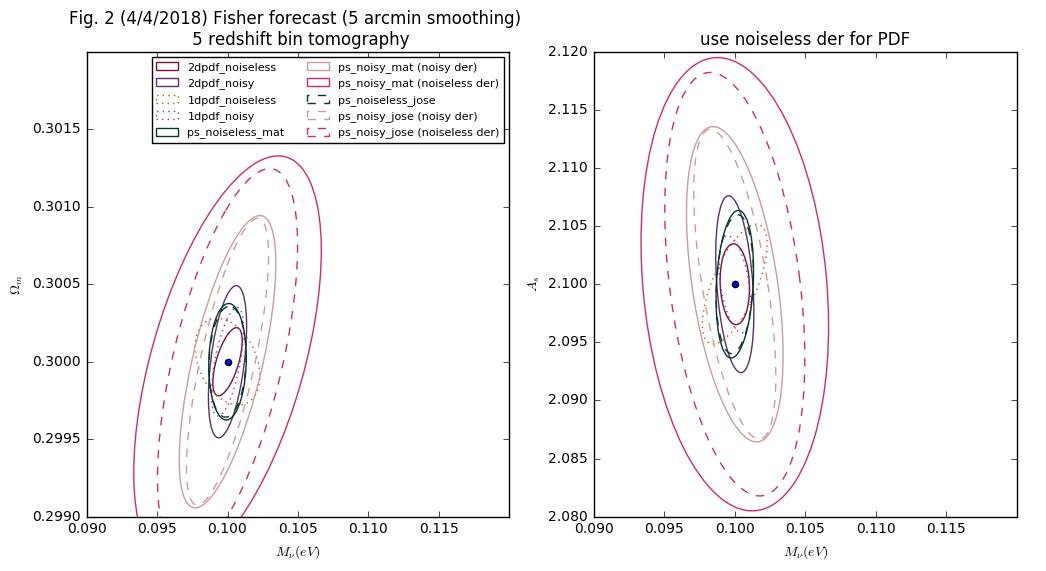

In [10]:
######## plot out all the fisher matrices, probably super busy..
lss = ['solid', 'solid', 
       'dotted','dotted', 
       'solid', 'solid', 'solid',
       'dashed','dashed','dashed']

f, (ax1,ax2) = subplots(1,2,figsize=(12,6))
ax1.scatter(0.1, 0.3)
ax2.scatter(0.1, 2.1)

jjj=0
seed(909)
colors = rand(10,3)
for iFF in Fisher_arr:
    #print jjj
    iF = iFF[0]
    icolor = colors[jjj]
    if jjj>6:
        icolor = colors[jjj-3]
    ilabel=set_names2[jjj]
    plotEllipse([0.1, 0.3], mat(iF).I[[0,1],:][:,[0,1]] ,icolor,lss[jjj],ilabel,ax1)
    plotEllipse([0.1, 2.1], mat(iF).I[[0,2],:][:,[0,2]] ,icolor,lss[jjj],ilabel,ax2)
    jjj+=1
ax1.set_xlim(0.09, 0.12)#(0.07,0.14)
ax1.set_ylim(0.299, .302)#(0.296,0.306)
ax2.set_xlim(0.09, 0.12)#(0.07,0.14)
ax2.set_ylim(2.08, 2.12)#(2.05,2.15)
ax1.set_xlabel(r'$M_\nu(eV)$')
ax1.set_ylabel(r'$\Omega_m$')
ax2.set_xlabel(r'$M_\nu(eV)$')
ax2.set_ylabel(r'$A_s$')
ax1.legend(fontsize=8,frameon=1,ncol=2)
ax1.set_title('Fig. 2 (4/4/2018) Fisher forecast (5 arcmin smoothing) \n 5 redshift bin tomography')
#ax2.set_title('use noisy der for PDF')
ax2.set_title('use noiseless der for PDF')
show()

In [11]:
psI_Mat_r100 = array([load('stats_avg/output_eb_5000_s4_r100_ALL_igalXigal_%.1f_%.1f.npy'
                     %(iz, iz)) for iz in z_source])
psI_Mat_r500 = array([load('stats_avg/output_eb_5000_s4_r500_ALL_igalXigal_%.1f_%.1f.npy'
                     %(iz, iz)) for iz in z_source])
psI_Mat_r500b = array([load('stats_avg/output_eb_5000_s4_r500b_ALL_igalXigal_%.1f_%.1f.npy'
                     %(iz, iz)) for iz in z_source])
psI_Mat_r700 = array([load('stats_avg/output_eb_5000_s4_r700_ALL_igalXigal_%.1f_%.1f.npy'
                     %(iz, iz)) for iz in z_source])
psI_Mat_r900 = array([load('stats_avg/output_eb_5000_s4_r900_ALL_igalXigal_%.1f_%.1f.npy'
                     %(iz, iz)) for iz in z_source])

psI_Mat_flat_r100 = swapaxes(psI_Mat_r100,0,1).reshape(101,-1)
psI_Mat_flat_r500 = swapaxes(psI_Mat_r500,0,1).reshape(101,-1)
psI_Mat_flat_r500b = swapaxes(psI_Mat_r500b,0,1).reshape(101,-1)
psI_Mat_flat_r700 = swapaxes(psI_Mat_r700,0,1).reshape(101,-1)
psI_Mat_flat_r900 = swapaxes(psI_Mat_r900,0,1).reshape(101,-1)

cov_ps_arr = [[icov, ips] for icov in [covpsI_Mat, covpsN_Mat]
               for ips in [psI_Mat_flat_r100, psI_Mat_flat_r500, psI_Mat_flat_r500b, 
                           psI_Mat_flat_r700, psI_Mat_flat_r900,psI_Mat_flat]]
covI_ps_arr = [ mat(cov_ps_arr[i][0]*(12.25/2e4)).I for i in range(len(cov_ps_arr))]

set_ps = [[icovname, ipsname] for icovname in ['covI','covN']
         for ipsname in['r100', 'r500', 'r500b','r700','r900','r1000']]

Na_arr = [100.,500.,500.,700.,900.,1000.]*2
ir_arr = (0.1, 0.15, 0.2, 0.3)
Ferrors = zeros((len(ir_arr), len(set_ps), 3))
Fmats = zeros((len(ir_arr), len(set_ps), 3, 3))
j=0
for ir in ir_arr:
    params_der = array([array([0.30,0.1,2.1])*(identity(3)*x+ones((3,3))) for x in (ir,-ir)])

    der_arr = []
    #interp_arr = []
    for i in range(len(cov_ps_arr)):
        iinterp = WLanalysis.buildInterpolator(cov_ps_arr[i][1], params[:,[1,0,2]])
        ider = array([(iinterp(params_der[0][i]) - iinterp(params_der[1][i]))/(fidu_params[i]*ir) for i in range(3)])
        der_arr.append(ider)
        #interp_arr.append(iinterp)


    Fisher_ps_arr = [Fisher(covI_ps_arr[i], der_arr[i], ir=ir, Na=Na_arr[i]) for i in range(len(cov_ps_arr))]
    #print 'Fisher error on [Mnu, omega_m, A_s], step size (%s)'%(ir)
    i=0
    for iF in Fisher_ps_arr:
        #print iF[1], set_ps[i]
        Ferrors [j,i]=iF[1]
        Fmats[j,i]=iF[0]
        i+=1
    j+=1
    
Ferrors.shape #(4, 12, 3)
Nsims = [100, 500, 500, 700, 900, 1000]

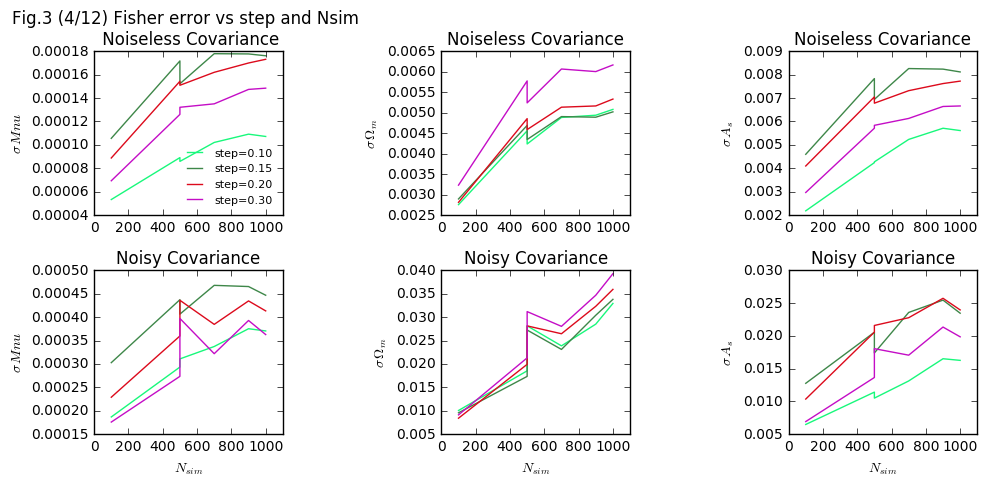

In [12]:
seed(55)

f, axes = subplots(2,3, figsize=(10, 5))
for i in range(Ferrors.shape[0]):
    icolor = rand(3)
    for j in range(Ferrors.shape[-1]):
        
        axes[0][j].plot(Nsims, Ferrors[i,:6,j], '-',color=icolor,label='step=%.2f'%(ir_arr[i]))
        axes[1][j].plot(Nsims, Ferrors[i,6:,j], '-', color=icolor)# label='step=%.1f'%(ir_arr[i]))
        axes[0][j].set_xlim(0, 1100)
        axes[1][j].set_xlim(0, 1100)
        axes[1][j].set_xlabel('$N_{sim}$')
        axes[0][j].set_ylabel('$\sigma\, %s$'% (['Mnu', '\Omega_m', 'A_s'][j]))
        axes[1][j].set_ylabel('$\sigma\, %s$'% (['Mnu', '\Omega_m', 'A_s'][j]))
        axes[0][j].set_title('Noiseless Covariance')
        axes[1][j].set_title('Noisy Covariance')

axes[0][0].legend(fontsize=8, frameon=0, loc=0)
axes[0][0].legend(fontsize=8, frameon=0, loc=0)
axes[0][0].set_title('Fig.3 (4/12) Fisher error vs step and Nsim \n Noiseless Covariance')

plt.tight_layout()
show()

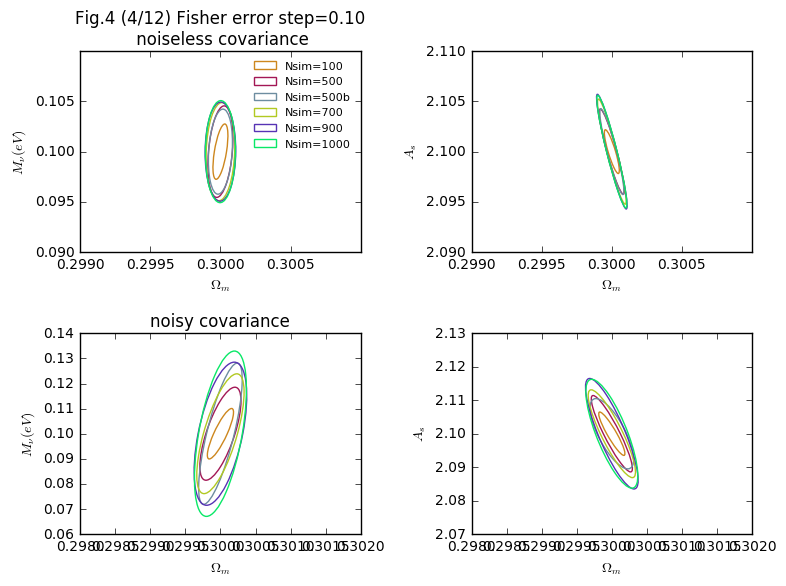

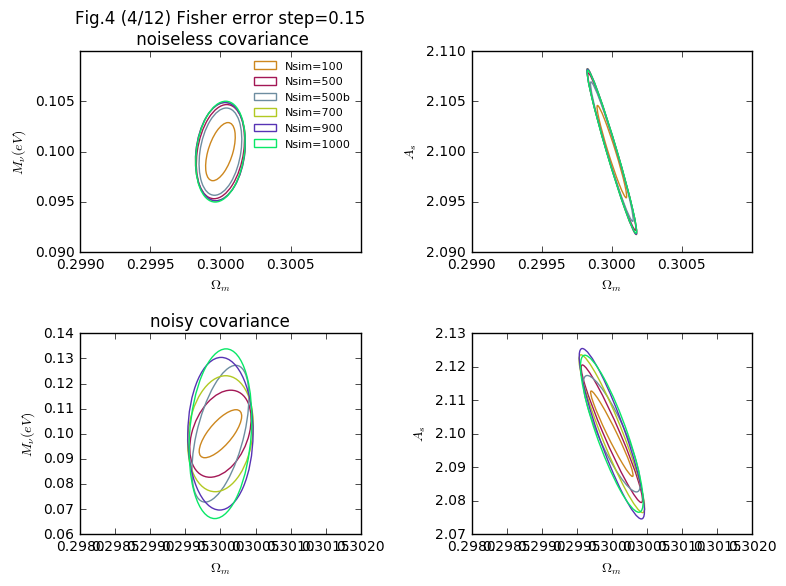

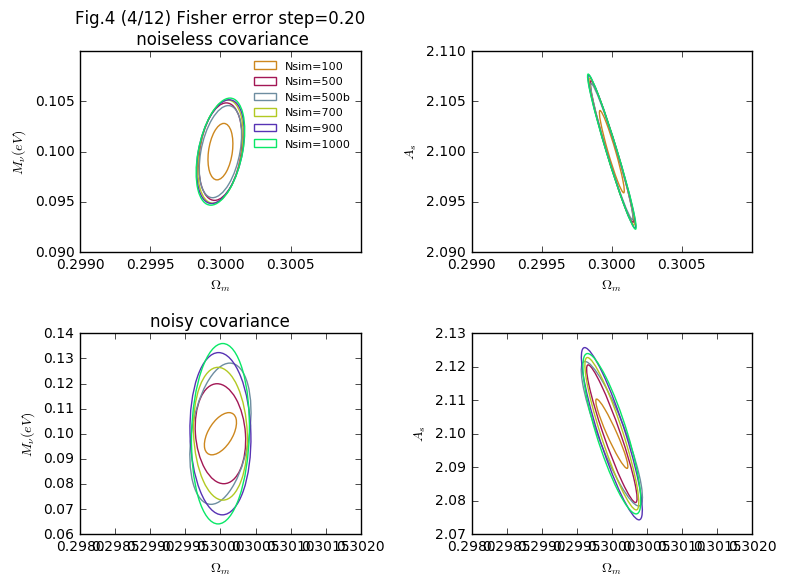

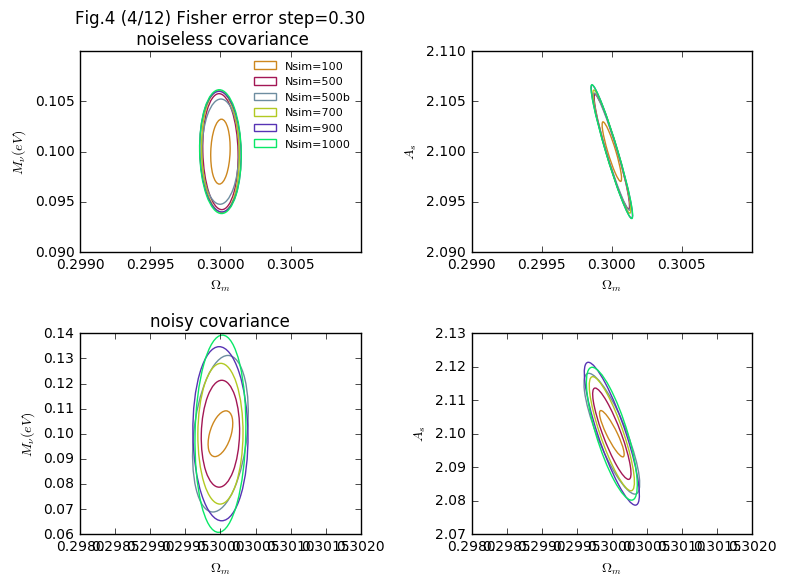

In [13]:
######### now put all the fisher matrices on 1 plot
### Fmats.shape = (4, 12, 3, 3)
lss='solid'
fnNsim=['r100', 'r500', 'r500b','r700','r900','r1000']
for i in range(Ferrors.shape[0]):
    f, (ax1,ax2) = subplots(2,2,figsize=(8,6))
    seed(999)#(909)
    for k in range(6):
        icolor = rand(3)
        iF = Fmats[i,k]
        iFN = Fmats[i,k+6]
        plotEllipse([0.3, 0.1], mat(iF).I[[0,1],:][:,[0,1]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax1[0])
        plotEllipse([0.3, 2.1], mat(iF).I[[0,2],:][:,[0,2]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax1[1])
        plotEllipse([0.3, 0.1], mat(iFN).I[[0,1],:][:,[0,1]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax2[0])
        plotEllipse([0.3, 2.1], mat(iFN).I[[0,2],:][:,[0,2]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax2[1])
    ax1[0].set_xlim(0.299, .301)
    ax1[0].set_ylim(0.09, 0.11)
    ax1[1].set_xlim(0.299, 0.301)
    ax1[1].set_ylim(2.09, 2.11)
    ax2[0].set_xlim(0.298, .302)
    ax2[0].set_ylim(0.06, 0.14)
    ax2[1].set_xlim(0.298, 0.302)
    ax2[1].set_ylim(2.07, 2.13)
    for iax in (ax1,ax2):
        iax[0].set_xlabel(r'$\Omega_m$')
        iax[0].set_ylabel(r'$M_\nu(eV)$')
        iax[1].set_xlabel(r'$\Omega_m$')
        iax[1].set_ylabel(r'$A_s$')
    ax1[0].legend(fontsize=8,frameon=0,ncol=1)
    ax1[0].set_title('Fig.4 (4/12) Fisher error step=%.2f\n noiseless covariance'%(ir_arr[i]))
    ax2[0].set_title('noisy covariance')
    plt.tight_layout()
    show()

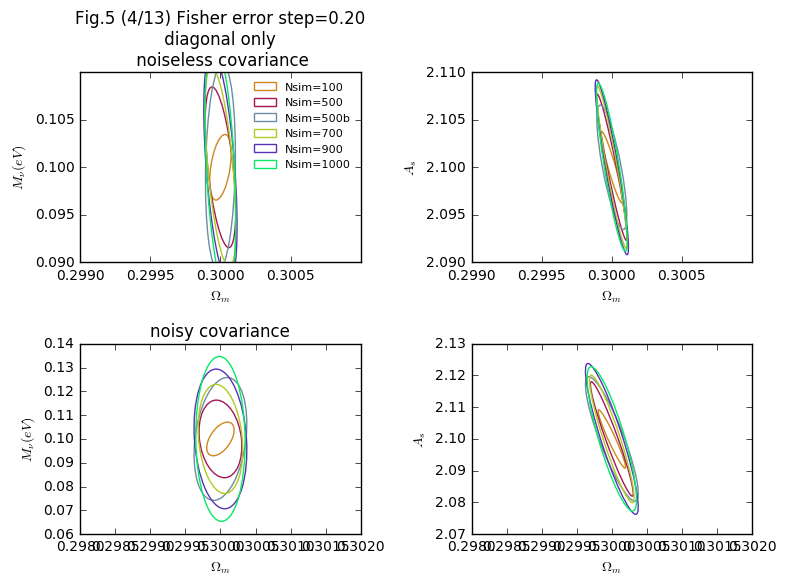

In [14]:
################## now use only diagonal component of the covariance
covpsI_Mat_diag = zeros(shape=covpsI_Mat.shape)
covpsN_Mat_diag = zeros(shape=covpsI_Mat.shape)

covpsI_Mat_diag[diag_indices(covpsI_Mat.shape[0])] = covpsI_Mat[diag_indices(covpsI_Mat.shape[0])]
covpsN_Mat_diag[diag_indices(covpsI_Mat.shape[0])] = covpsN_Mat[diag_indices(covpsI_Mat.shape[0])]

cov_ps_arr = [[icov, ips] for icov in [covpsI_Mat_diag, covpsN_Mat_diag]
               for ips in [psI_Mat_flat_r100, psI_Mat_flat_r500, psI_Mat_flat_r500b, 
                           psI_Mat_flat_r700, psI_Mat_flat_r900,psI_Mat_flat]]
covI_ps_arr = [ mat(cov_ps_arr[i][0]*(12.25/2e4)).I for i in range(len(cov_ps_arr))]

set_ps = [[icovname, ipsname] for icovname in ['covI','covN']
         for ipsname in['r100', 'r500', 'r500b','r700','r900','r1000']]

Na_arr = [100.,500.,500.,700.,900.,1000.]*2
ir_arr = (0.1, 0.15, 0.2, 0.3)
Ferrors = zeros((len(ir_arr), len(set_ps), 3))
Fmats = zeros((len(ir_arr), len(set_ps), 3, 3))
j=0
for ir in ir_arr:
    params_der = array([array([0.30,0.1,2.1])*(identity(3)*x+ones((3,3))) for x in (ir,-ir)])

    der_arr = []
    #interp_arr = []
    for i in range(len(cov_ps_arr)):
        iinterp = WLanalysis.buildInterpolator(cov_ps_arr[i][1], params[:,[1,0,2]])
        ider = array([(iinterp(params_der[0][i]) - iinterp(params_der[1][i]))/(fidu_params[i]*ir) for i in range(3)])
        der_arr.append(ider)
        #interp_arr.append(iinterp)


    Fisher_ps_arr = [Fisher(covI_ps_arr[i], der_arr[i], ir=ir, Na=Na_arr[i]) for i in range(len(cov_ps_arr))]
    #print 'Fisher error on [Mnu, omega_m, A_s], step size (%s)'%(ir)
    i=0
    for iF in Fisher_ps_arr:
        #print iF[1], set_ps[i]
        Ferrors [j,i]=iF[1]
        Fmats[j,i]=iF[0]
        i+=1
    j+=1
    
Ferrors.shape #(4, 12, 3)
Nsims = [100, 500, 500, 700, 900, 1000]

######### now put all the fisher matrices on 1 plot
### Fmats.shape = (4, 12, 3, 3)
lss='solid'
fnNsim=['r100', 'r500', 'r500b','r700','r900','r1000']
for i in (2,):#range(Ferrors.shape[0]):
    f, (ax1,ax2) = subplots(2,2,figsize=(8,6))
    seed(999)#(909)
    for k in range(6):
        icolor = rand(3)
        iF = Fmats[i,k]
        iFN = Fmats[i,k+6]
        plotEllipse([0.3, 0.1], mat(iF).I[[0,1],:][:,[0,1]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax1[0])
        plotEllipse([0.3, 2.1], mat(iF).I[[0,2],:][:,[0,2]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax1[1])
        plotEllipse([0.3, 0.1], mat(iFN).I[[0,1],:][:,[0,1]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax2[0])
        plotEllipse([0.3, 2.1], mat(iFN).I[[0,2],:][:,[0,2]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax2[1])
    ax1[0].set_xlim(0.299, .301)
    ax1[0].set_ylim(0.09, 0.11)
    ax1[1].set_xlim(0.299, 0.301)
    ax1[1].set_ylim(2.09, 2.11)
    ax2[0].set_xlim(0.298, .302)
    ax2[0].set_ylim(0.06, 0.14)
    ax2[1].set_xlim(0.298, 0.302)
    ax2[1].set_ylim(2.07, 2.13)
    for iax in (ax1,ax2):
        iax[0].set_xlabel(r'$\Omega_m$')
        iax[0].set_ylabel(r'$M_\nu(eV)$')
        iax[1].set_xlabel(r'$\Omega_m$')
        iax[1].set_ylabel(r'$A_s$')
    ax1[0].legend(fontsize=8,frameon=0,ncol=1)
    ax1[0].set_title('Fig.5 (4/13) Fisher error step=%.2f\n diagonal only \n noiseless covariance'%(ir_arr[i]))
    ax2[0].set_title('noisy covariance')
    plt.tight_layout()
    show()

In [15]:
ngal_arr = np.array([8.83, 13.25, 11.15, 7.36, 4.26])
Clnn =  array([0.3**2 / ngal / 1.18e7 for ngal in ngal_arr])
print Clnn

[  8.63773346e-10   5.75631596e-10   6.84046515e-10   1.03629329e-09
   1.79040344e-09]


In [16]:
pscambI = load('jiaNoiseFree.npy')[range(5),range(5)]
pscambN = load('jiaNoisy.npy')[range(5),range(5)]

ellcamb = linspace(100, 3000,21)[:-1]+72.5
dellcamb = 145.
covpsI_camb = zeros((100,100))
covpsN_camb = zeros((100,100))
fsky=0.5

covpsI_camb[diag_indices(100)] = array([2.0/(2*ellcamb+1)/fsky/dellcamb*pscambI[i]**2 for i in range(5)]).flatten()
covpsN_camb[diag_indices(100)] = array([2.0/(2*ellcamb+1)/fsky/dellcamb*pscambN[i]**2 for i in range(5)]).flatten()

pscambI.shape

(5, 20)

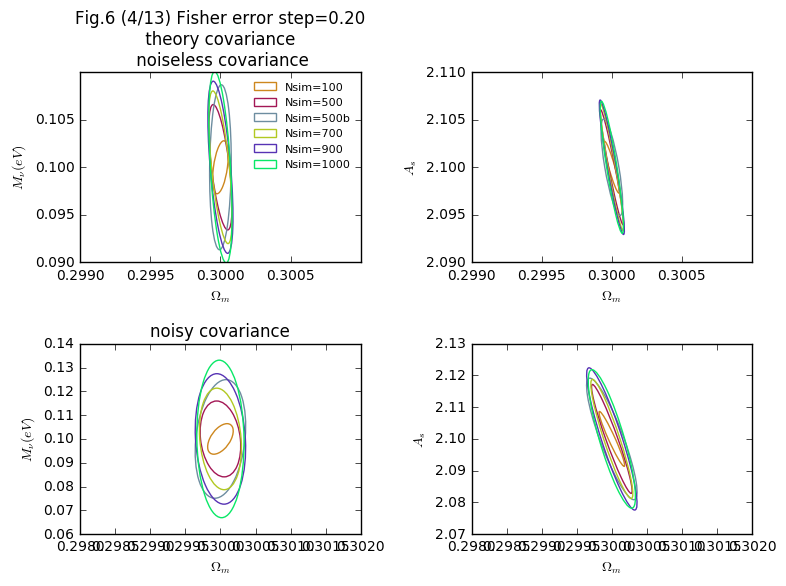

In [17]:
############## now test with theory covariance

cov_ps_arr = [[icov, ips] for icov in [covpsI_camb, covpsN_camb]
               for ips in [psI_Mat_flat_r100, psI_Mat_flat_r500, psI_Mat_flat_r500b, 
                           psI_Mat_flat_r700, psI_Mat_flat_r900,psI_Mat_flat]]
covI_ps_arr = [ mat(cov_ps_arr[i][0]).I for i in range(len(cov_ps_arr))]

set_ps = [[icovname, ipsname] for icovname in ['covI','covN']
         for ipsname in['r100', 'r500', 'r500b','r700','r900','r1000']]

Na_arr = [100.,500.,500.,700.,900.,1000.]*2
ir_arr = (0.1, 0.15, 0.2, 0.3)
Ferrors = zeros((len(ir_arr), len(set_ps), 3))
Fmats = zeros((len(ir_arr), len(set_ps), 3, 3))
j=0
for ir in ir_arr:
    params_der = array([array([0.30,0.1,2.1])*(identity(3)*x+ones((3,3))) for x in (ir,-ir)])

    der_arr = []
    #interp_arr = []
    for i in range(len(cov_ps_arr)):
        iinterp = WLanalysis.buildInterpolator(cov_ps_arr[i][1], params[:,[1,0,2]])
        ider = array([(iinterp(params_der[0][i]) - iinterp(params_der[1][i]))/(fidu_params[i]*ir) for i in range(3)])
        der_arr.append(ider)
        #interp_arr.append(iinterp)


    Fisher_ps_arr = [Fisher(covI_ps_arr[i], der_arr[i], ir=ir, Na=Na_arr[i]) for i in range(len(cov_ps_arr))]
    #print 'Fisher error on [Mnu, omega_m, A_s], step size (%s)'%(ir)
    i=0
    for iF in Fisher_ps_arr:
        #print iF[1], set_ps[i]
        Ferrors [j,i]=iF[1]
        Fmats[j,i]=iF[0]
        i+=1
    j+=1
    
Ferrors.shape #(4, 12, 3)
Nsims = [100, 500, 500, 700, 900, 1000]

######### now put all the fisher matrices on 1 plot
### Fmats.shape = (4, 12, 3, 3)
lss='solid'
fnNsim=['r100', 'r500', 'r500b','r700','r900','r1000']
for i in (2,):#range(Ferrors.shape[0]):
    f, (ax1,ax2) = subplots(2,2,figsize=(8,6))
    seed(999)#(909)
    for k in range(6):
        icolor = rand(3)
        iF = Fmats[i,k]
        iFN = Fmats[i,k+6]
        plotEllipse([0.3, 0.1], mat(iF).I[[0,1],:][:,[0,1]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax1[0])
        plotEllipse([0.3, 2.1], mat(iF).I[[0,2],:][:,[0,2]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax1[1])
        plotEllipse([0.3, 0.1], mat(iFN).I[[0,1],:][:,[0,1]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax2[0])
        plotEllipse([0.3, 2.1], mat(iFN).I[[0,2],:][:,[0,2]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax2[1])
    ax1[0].set_xlim(0.299, .301)
    ax1[0].set_ylim(0.09, 0.11)
    ax1[1].set_xlim(0.299, 0.301)
    ax1[1].set_ylim(2.09, 2.11)
    ax2[0].set_xlim(0.298, .302)
    ax2[0].set_ylim(0.06, 0.14)
    ax2[1].set_xlim(0.298, 0.302)
    ax2[1].set_ylim(2.07, 2.13)
    for iax in (ax1,ax2):
        iax[0].set_xlabel(r'$\Omega_m$')
        iax[0].set_ylabel(r'$M_\nu(eV)$')
        iax[1].set_xlabel(r'$\Omega_m$')
        iax[1].set_ylabel(r'$A_s$')
    ax1[0].legend(fontsize=8,frameon=0,ncol=1)
    ax1[0].set_title('Fig.6 (4/13) Fisher error step=%.2f\n theory covariance \n noiseless covariance'%(ir_arr[i]))
    ax2[0].set_title('noisy covariance')
    plt.tight_layout()
    show()

In [79]:
Na, Nb = 41,51
Mnu_arr = linspace(0.08, 0.12, Na)
Om_arr = linspace(0.299, 0.301, Nb)
#param_arr= array(meshgrid(Mnu_arr, Om_arr)).reshape(2,-1).T

chiplans = zeros((6,Na,Nb))

psi1000 = WLanalysis.buildInterpolator(psI_Mat_flat, params)
psi100 = WLanalysis.buildInterpolator(psI_Mat_flat_r100, params)
psi500 = WLanalysis.buildInterpolator(psI_Mat_flat_r500, params)
psi500b = WLanalysis.buildInterpolator(psI_Mat_flat_r500b, params)
psi700 = WLanalysis.buildInterpolator(psI_Mat_flat_r700, params)
psi900 = WLanalysis.buildInterpolator(psI_Mat_flat_r900, params)

covI_inverse = mat(covpsI_Mat*(12.25/2e4)).I
for iNa in range(Na):
    for iNb in range(Nb):
        
        i=0
        for iinterp in [psi100,psi500,psi500b,psi700,psi900,psi1000]:
            idiffi = iinterp((Mnu_arr[iNa], Om_arr[iNb], 2.1)) - iinterp((0.1, 0.3, 2.1))
            chiplans[i, iNa, iNb] = float(mat(idiffi)*covI_inverse*mat(idiffi).T) 
            i+=1

In [80]:
Mnu_arrN = linspace(0.0, 0.2, Na)
Om_arrN = linspace(0.29, 0.31, Nb)

chiplansNCov = zeros((6,Na,Nb))

covN_inverse = mat(covpsN_Mat*(12.25/2e4)).I

for iNa in range(Na):
    for iNb in range(Nb):
        
        i=0
        for iinterp in [psi100,psi500,psi500b,psi700,psi900,psi1000]:
            idiffi = iinterp((Mnu_arrN[iNa], Om_arrN[iNb], 2.1)) - iinterp((0.1, 0.3, 2.1))
            chiplansNCov[i, iNa, iNb] = float(mat(idiffi)*covN_inverse*mat(idiffi).T) 
            i+=1

In [ ]:
Fmats = zeros((len(set_ps), 2, 2))
j=0
for ir in ir_arr:
    params_der = array([array([0.30,0.1,2.1])*(identity(3)*x+ones((3,3))) for x in (ir,-ir)])

    der_arr = []
    #interp_arr = []
    for i in range(len(cov_ps_arr)):
        iinterp = WLanalysis.buildInterpolator(cov_ps_arr[i][1], params[:,[1,0,2]])
        ider = array([(iinterp(params_der[0][i]) - iinterp(params_der[1][i]))/(fidu_params[i]*ir) for i in range(3)])
        der_arr.append(ider)
        #interp_arr.append(iinterp)


    Fisher_ps_arr = [Fisher(covI_ps_arr[i], der_arr[i], ir=ir, Na=Na_arr[i]) for i in range(len(cov_ps_arr))]
    #print 'Fisher error on [Mnu, omega_m, A_s], step size (%s)'%(ir)
    i=0
    for iF in Fisher_ps_arr:
        #print iF[1], set_ps[i]
        Ferrors [j,i]=iF[1]
        Fmats[j,i]=iF[0]
        i+=1
    j+=1

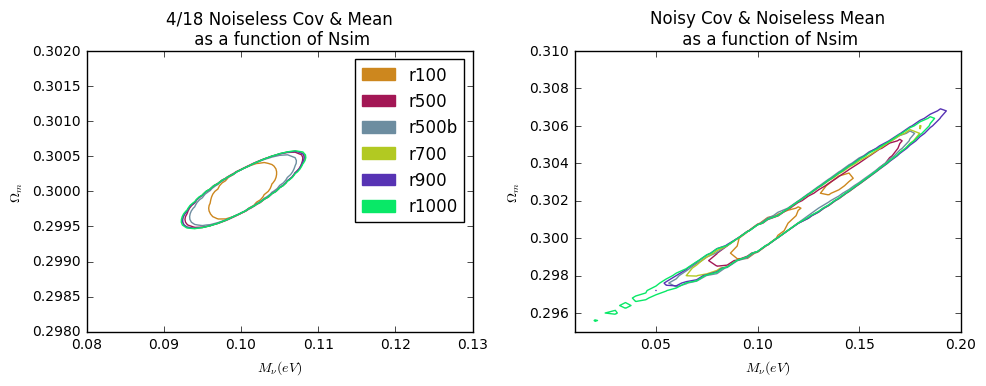

In [127]:
############# plotting
labels = ['r100', 'r500', 'r500b','r700','r900','r1000']

seed(999)
X,Y = meshgrid(Mnu_arr, Om_arr)
Xn, Yn = meshgrid(Mnu_arrN, Om_arrN)
f, (ax1,ax2)  = subplots(1,2,figsize=(10,4))

css = []
for i in range(6):
    icolor=rand(3)  
    
    ichi = chiplans[i]
    ichiN = chiplansNCov[i]
    ip = exp(-0.5*ichi).T
    ipN = exp(-0.5*ichiN).T
    il = sort(WLanalysis.findlevel(ip))
    ilN = sort(WLanalysis.findlevel(ipN))
    ax1.contour(X, Y, ip,levels=[il[1],], origin='lower',aspect='auto',interpolation='nearest',colors=[icolor,],label=labels[i],lw=0.5)
    ax2.contour(Xn, Yn, ipN,levels=[ilN[1],], origin='lower',aspect='auto',interpolation='nearest',colors=[icolor,],label=labels[i],lw=0.5)

seed(999)    
proxy=[plt.Rectangle((0,0),1,0.5,ec=icolor, fc = icolor) for icolor in rand(6,3)]

ax1.set_ylim(0.298, .302)
ax1.set_xlim(0.08, 0.13)
ax2.set_ylim(0.295, .31)
ax2.set_xlim(0.01, 0.2)
ax2.set_xlabel(r'$M_\nu(eV)$')
ax2.set_ylabel(r'$\Omega_m$')


ax1.legend(proxy, labels)

# ax1.legend(fontsize=10, frameon=0, loc=0)
ax1.set_xlabel(r'$M_\nu(eV)$')
ax1.set_ylabel(r'$\Omega_m$')
ax1.set_title('Fig.7 (4/18) Noiseless Cov & Mean\n as a function of Nsim')
ax2.set_title('Noisy Cov & Noiseless Mean\n as a function of Nsim')
plt.tight_layout()
show()

Fisher error on [Mnu, omega_m, A_s], ell range 172.5-317.5
[ 0.00149325  0.11390601  0.04520602] r100
[ 0.00056902  0.03442492  0.03335405] r500
[ 0.00084131  0.06535081  0.03299299] r500b
[ 0.0005906   0.04947361  0.03782267] r700
[ 0.00069408  0.07490317  0.04808818] r900
[ 0.00062359  0.08089787  0.03938848] r1000
Fisher error on [Mnu, omega_m, A_s], ell range 462.5-607.5
[ 0.00050911  0.0226533   0.02236258] r100
[ 0.0019565   0.08414189  0.12189635] r500
[ 0.00107296  0.08603315  0.06872786] r500b
[ 0.00151806  0.11579869  0.10597679] r700
[ 0.00153598  0.11040867  0.09945902] r900
[ 0.00135991  0.10122063  0.08955138] r1000
Fisher error on [Mnu, omega_m, A_s], ell range 752.5-897.5
[ 0.00106324  0.01584385  0.05457378] r100
[ 0.00161985  0.10295863  0.12252064] r500
[ 0.00164183  0.7217313   0.26045624] r500b
[ 0.00143602  0.11895048  0.11585368] r700
[ 0.00197777  0.19261053  0.16881142] r900
[ 0.001623    0.16070598  0.13158451] r1000
Fisher error on [Mnu, omega_m, A_s], ell ra

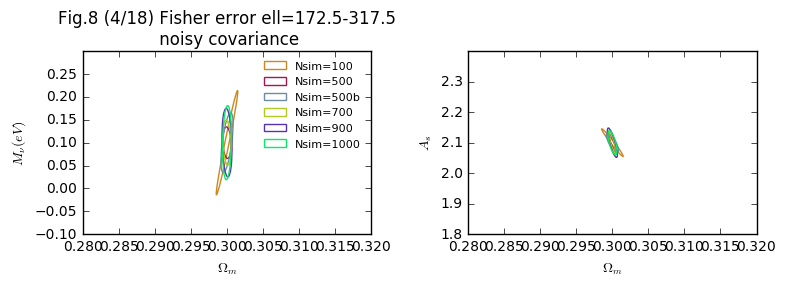

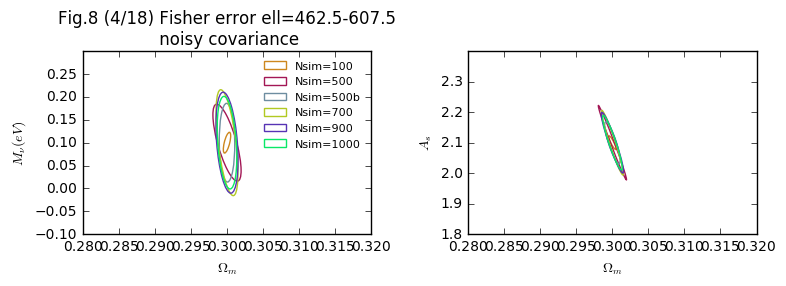

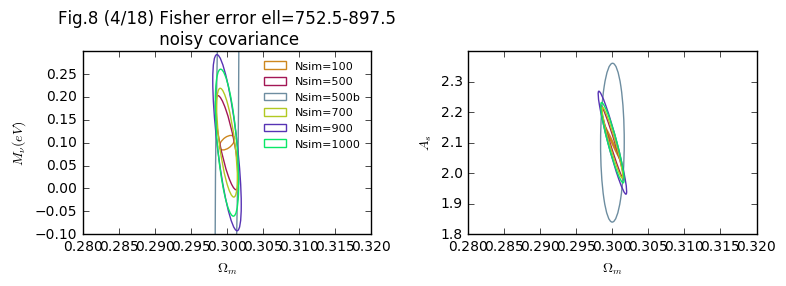

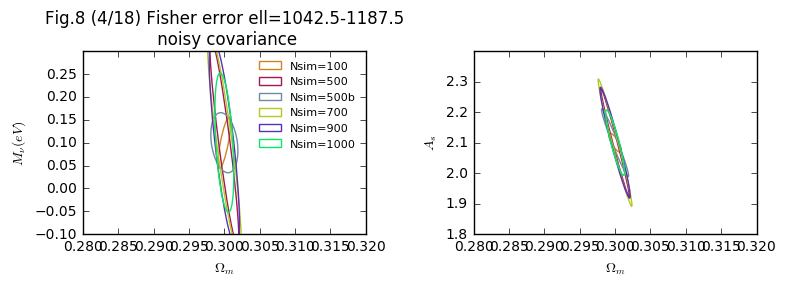

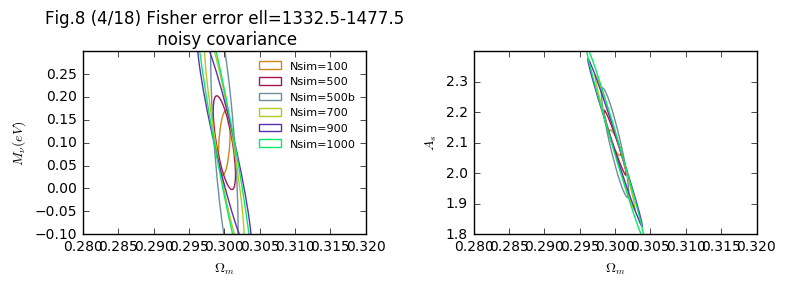

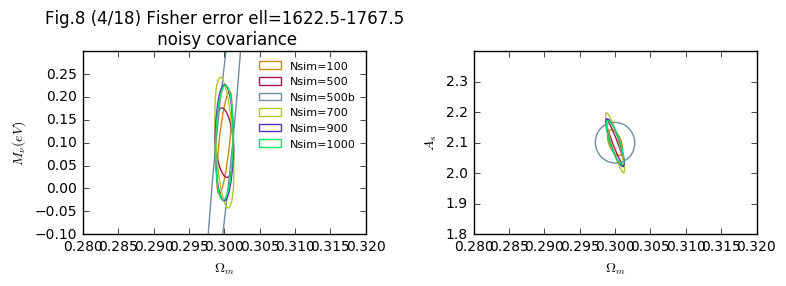

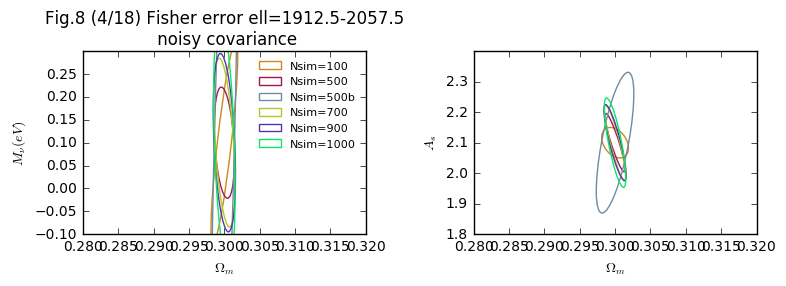

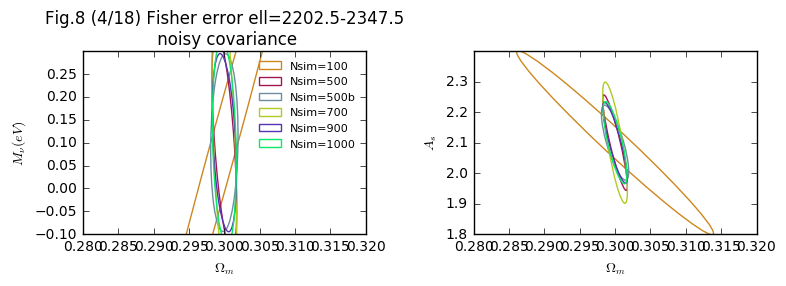

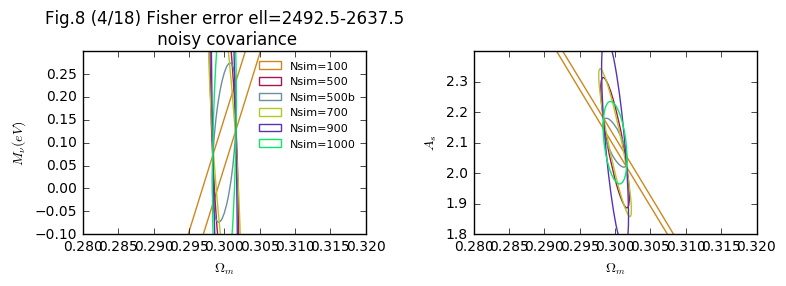

In [142]:
############ next let's scan through each ell range, see which ones are impacted most

ps_full_arr = [psI_Mat_flat_r100, psI_Mat_flat_r500, psI_Mat_flat_r500b,
               psI_Mat_flat_r700, psI_Mat_flat_r900,psI_Mat_flat]
## use covariance: covN_inverse, labels
Nell=2
idx_ell = arange(0, 21, Nell)

ir=0.2
params_der = array([array([0.30,0.1,2.1])*(identity(3)*x+ones((3,3))) for x in (ir,-ir)])
Na_arr = [100.,500.,500.,700.,900.,1000.]*2
ir_arr = (0.1, 0.15, 0.2, 0.3)
FerrorsEll = zeros((20/Nell-1, len(ps_full_arr), 3))
FmatsEll = zeros((20/Nell-1, len(ps_full_arr), 3, 3))
j=0
for iii in range(20/Nell-1):
    der_arr = []
    iidx = concatenate([arange(idx_ell[iii], idx_ell[iii+1])+k for k in arange(0, 100,20)])
    icov = covpsN_Mat[iidx][:,iidx]
    icovI = mat(icov*(12.25/2e4)).I
    for i in range(len(ps_full_arr)):
        
        ips = ps_full_arr[i][:,iidx]
        iinterp = WLanalysis.buildInterpolator(ips, params[:,[1,0,2]])
        ider = array([(iinterp(params_der[0][i]) - iinterp(params_der[1][i]))/(fidu_params[i]*ir) for i in range(3)])
        der_arr.append(ider)


    Fisher_ps_arr = [Fisher(icovI, der_arr[i], ir=ir, Na=Na_arr[i]) for i in range(len(ps_full_arr))]
    print 'Fisher error on [Mnu, omega_m, A_s], ell range %s-%s'%(ellcamb[idx_ell[iii]],ellcamb[idx_ell[iii+1]-1])
    i=0
    for iF in Fisher_ps_arr:
        print iF[1], labels[i]
        FerrorsEll [j,i]=iF[1]
        FmatsEll[j,i]=iF[0]
        i+=1
    j+=1

######### now put all the fisher matrices on 1 plot
### Fmats.shape = (4, 12, 3, 3)
lss='solid'
fnNsim=['r100', 'r500', 'r500b','r700','r900','r1000']
for i in range(FerrorsEll.shape[0]):
    f, (ax1,ax2) = subplots(1,2,figsize=(8,3))
    seed(999)#(909)
    for k in range(6):
        icolor = rand(3)
        iF = FmatsEll[i,k]
        plotEllipse([0.3, 0.1], mat(iF).I[[0,1],:][:,[0,1]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax1)
        plotEllipse([0.3, 2.1], mat(iF).I[[0,2],:][:,[0,2]] ,icolor,lss,'Nsim=%s'%(fnNsim[k][1:]),ax2)

    ax1.set_xlim(0.28, .32)
    ax1.set_ylim(-0.1, 0.3)
    ax2.set_xlim(0.28, 0.32)
    ax2.set_ylim(1.8, 2.4)
    ax1.set_xlabel(r'$\Omega_m$')
    ax1.set_ylabel(r'$M_\nu(eV)$')
    ax2.set_xlabel(r'$\Omega_m$')
    ax2.set_ylabel(r'$A_s$')
    ax1.legend(fontsize=8,frameon=0,ncol=1)
    ax1.set_title('Fig.8 (4/18) Fisher error ell=%s-%s\n noisy covariance'%(ellcamb[idx_ell[i]],ellcamb[idx_ell[i+1]-1]))
#     ax2.set_title('noisy covariance')
    plt.tight_layout()
    show()

In [131]:
Fmats.shape, psI_Mat_flat_r100.shape

((4, 6, 3, 3), (101, 100))

In [19]:
der2dI, der2dN, der1dI, der1dN = der_arr[:4]
print der2dI.shape, der2dN.shape, der1dI.shape, der1dN.shape

(3, 100) (3, 100) (3, 100) (3, 100)


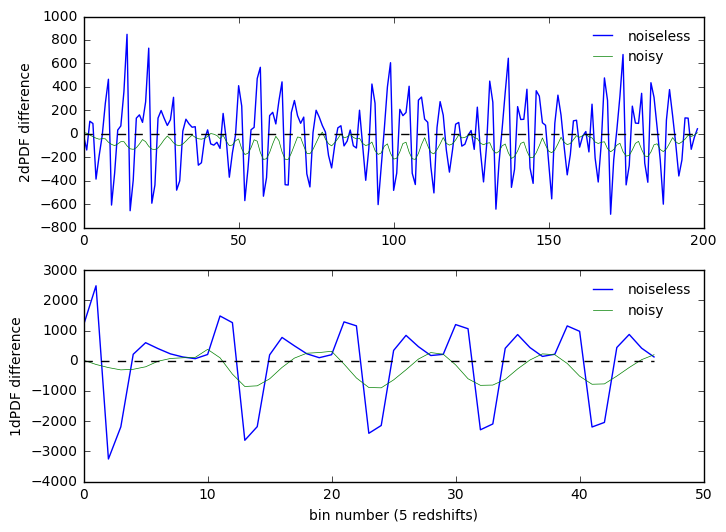

In [20]:
f, (ax1, ax2) = subplots(2,1,figsize=(8,6))
seed(35)
for i in (0,):
    ax1.plot(pdf2dI_flat[0]-pdf2dI_flat[10], '-', lw=1,label='noiseless')
    ax1.plot(pdf2dN_flat[0]-pdf2dN_flat[10], '-', lw=0.5,label='noisy')
    ax1.plot(zeros(len(pdf2dI_flat[0])),'k--')
    ax2.plot(pdf1dI_flat[0]-pdf1dI_flat[10], '-', lw=1,label='noiseless')
    ax2.plot(pdf1dN_flat[0]-pdf1dN_flat[10], '-', lw=0.5,label='noisy')
    ax2.plot(zeros(len(pdf1dI_flat[0])),'k--')
#ax1.set_ylim(-1000,1000)
ax2.set_xlabel('bin number (5 redshifts)')
ax1.set_ylabel('2dPDF difference')
ax2.set_ylabel('1dPDF difference')
ax1.legend(loc=0,frameon=0, fontsize=10)
ax2.legend(loc=0,frameon=0, fontsize=10)
show()

In [21]:
pdf1dmodel9i = load ('test/test1dipdf_model10.npy')
pdf1dmodel0i = load ('test/test1dipdf_model0.npy')
pdf1dmodel9n = load ('test/test1dnpdf_model10.npy')
pdf1dmodel0n = load ('test/test1dnpdf_model0.npy')
pdf1dmodel9i.shape

(1000, 80)

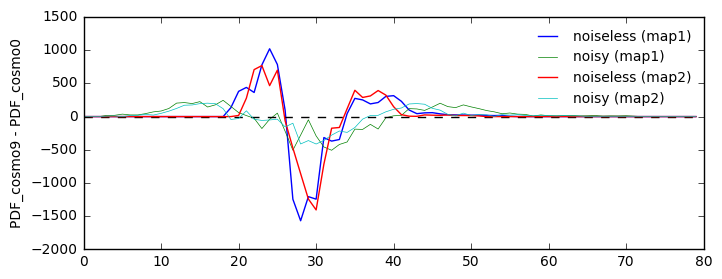

In [22]:
f, ax1 = subplots(1,1,figsize=(8,3))
seed(35)
for i in (0,):
    ax1.plot(pdf1dmodel0i[0]-pdf1dmodel9i[0],  lw=1,label='noiseless (map1)')
    ax1.plot(pdf1dmodel0n[0]-pdf1dmodel9n[0],  lw=0.5,label='noisy (map1)')
    ax1.plot(zeros(80),'k--')
    ax1.plot(pdf1dmodel0i[2]-pdf1dmodel9i[2], lw=1,label='noiseless (map2)')
    ax1.plot(pdf1dmodel0n[2]-pdf1dmodel9n[2], lw=0.5,label='noisy (map2)')

#ax1.set_ylim(-1000,1000)

ax1.set_ylabel('PDF_cosmo9 - PDF_cosmo0')
ax1.legend(loc=0,frameon=0, fontsize=10)
show()

In [23]:
########## here are the bin indices for each redshifts
#print idx_2dI
#print idx_1dI
edges2dI = arange(0, 5*(60/Nc)**2 +1, (60/Nc)**2)
edges1dI = arange(0, 6*(60/Nc)+1, (60/Nc))
bins2dI = [sum ( (idx_2dI>edges2dI[i]) & (idx_2dI < edges2dI[i+1])) for i in range(5)]
bins1dI = [sum ( (idx_1dI>edges1dI[i]) & (idx_1dI < edges1dI[i+1])) for i in range(5)]
edgeright2dI = [0,]+[sum (idx_2dI < edges2dI[i+1]) for i in range(5)]
edgeright1dI = [0,]+[sum (idx_1dI < edges1dI[i+1]) for i in range(5)]
print bins2dI, sum(bins2dI), edgeright2dI
print bins1dI, sum(bins1dI), edgeright1dI

[43, 43, 39, 37, 37] 199 [0, 43, 86, 125, 162, 199]
[10, 10, 9, 9, 9] 47 [0, 10, 20, 29, 38, 47]


In [24]:
# ######## now lets test for each redshift bins

# cov_arr2 = [cov2dI,cov2dN,
#            cov1dI,cov1dN,
#            covpsI_Mat,covpsN_Mat,covpsN_Mat,
#            covpsI_Jose,covpsN_Jose,covpsN_Jose]
# stats_arr2 = [pdf2dI_flat[1:], pdf2dN_flat[1:],
#              pdf1dI_flat[1:], pdf1dN_flat[1:],
#              psI_Mat_flat[1:], psN_Mat_flat[1:],psI_Mat_flat[1:],
#              psI_Jose_flat, psN_Jose_flat,psI_Jose_flat]

# i = -1
# for icov5z in cov_arr2:
#     i+=1    
#     if i<2:
#         iedges = edgeright2dI
#     elif i<4:
#         iedges = edgeright1dI
#     else:
#         isize = icov5z.shape[0]
#         iedges = arange(0, isize+1, isize/5)

#     f, (ax1,ax2) = subplots(1,2,figsize=(10,3))
#     ax1.scatter(0.1, 0.3)
#     ax2.scatter(0.1, 2.1)

#     jjj=0
#     seed(90)
#     colors = rand(10,3)   
#     for j in range(5):     
#         iL,iR = iedges[j:j+2]
#         icov1z = icov5z[iL:iR, iL:iR]
#         #print iL, iR, icov1z.shape
#         icov1zI = mat(icov1z*(12.25/2e4)).I
#         iider = der_arr[i][:,iL:iR]
#         iF1z = Fisher(icov1zI, iider)
        
#         iF = iF1z[0]
#         icolor = colors[jjj]
#         plotEllipse([0.1, 0.3], mat(iF).I[[0,1],:][:,[0,1]] ,icolor,'solid',z_source[j],ax1)
#         plotEllipse([0.1, 2.1], mat(iF).I[[0,2],:][:,[0,2]] ,icolor,'solid',z_source[j],ax2)
#         jjj+=1
        
#     ax1.set_xlim(0.09, 0.12)
#     ax1.set_ylim(0.299, .302)
#     ax2.set_xlim(0.09, 0.12)
#     ax2.set_ylim(2.08, 2.12)
#     if i>3:
#         ax1.set_xlim(0.06, 0.14)
#         ax1.set_ylim(0.28, .32)
#         ax2.set_xlim(0.06, 0.14)
#         ax2.set_ylim(2.0, 2.2)
#     ax1.set_xlabel(r'$M_\nu(eV)$')
#     ax1.set_ylabel(r'$\Omega_m$')
#     ax2.set_xlabel(r'$M_\nu(eV)$')
#     ax2.set_ylabel(r'$A_s$')
#     ax2.legend(fontsize=8,frameon=1,ncol=2)
#     ax1.set_title('Fig. 3.%i (4/4/2018) Fisher %s \n (5 arcmin smoothing) '%(i,set_names2[i]))
#     #ax2.set_title('use same bins for noisy/noiseless pdf\n jose ellmax=5000')
#     show()    

In [25]:
# seed(1)
# noisemap=rand(100,100)*100
# realmap1=rand(100,100)*30
# realmap2=rand(100,100)*20
# PS_noise = WLanalysis.PowerSpectrum(noisemap)[1]
# PS_real1 = WLanalysis.PowerSpectrum(realmap1)[1]
# PS_cross1 = WLanalysis.CrossCorrelate(noisemap, realmap1)[1]
# PS_real2 = WLanalysis.PowerSpectrum(realmap2)[1]
# PS_tot = WLanalysis.PowerSpectrum(noisemap+realmap1)[1]
# PS_tot2 = WLanalysis.PowerSpectrum(noisemap+realmap2)[1]
# PS_cross2 = WLanalysis.CrossCorrelate(noisemap, realmap2)[1]

# f, (ax1,ax2) = subplots(2,1)
# ax1.plot(PS_real1,'r--')
# ax1.plot(PS_real2,'b--')
# ax1.plot(PS_cross1,'r:')
# ax1.plot(PS_cross2,'b:')

# ax1.plot(PS_tot,'r-')
# ax1.plot(PS_tot2,'b-')
# ax1.plot(PS_noise,'gx')
# ax2.plot( (PS_tot-PS_real1-2*PS_cross1) / PS_noise,'r-')
# ax2.plot( (PS_tot2-PS_real2-2*PS_cross2) / PS_noise,'b-')
# ax2.set_ylim(0.99, 1.01)
# show()

In [26]:
# icovI = covI_arr2[-1] ## noisy covariance
# idr = der_arr[-1]

# for ix in linspace(0,2,6):
#     #seed(0)
#     inoise1 = 1 + (rand(3,idr.shape[1]) - 0.5)*ix
#     inoise2 = 1 + (rand(3,idr.shape[1]) - 0.5)*ix
#     iF = Fisher_2der(icovI, idr*inoise1,  idr*inoise2)
#     #iFnoise = Fisher(icovI, idr*(inoise-1))
#     print 'Noise Level: %.1f, 1 sigma CL: %s'%(ix,  iF[1])#, iFnoise[1]